# Project  Description : 

This project on Recommendation Systems is conducted on a data set of amazon reviews data.

#### Data Description :

Amazon Reviews data (data source) The repository has several datasets. For this case study, we are using the Electronics dataset.
Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/).

#### Dataset Link : https://drive.google.com/file/d/1ClBptsK3V5KgKXtK2GSRzFNAW7GnTPDW/view?usp=sharing

#### Domain :

E-commerce.

#### Attribute Information :

    ● userId    : Every user identified with a unique id. 
    ● productId : Every product identified with a unique id. 
    ● Rating    : Rating of the corresponding product by the corresponding user.        
    ● timestamp : Time of the rating ( ignore this column for this exercise).        

#### Learning Outcomes :

    ● Exploratory Data Analysis.
    ● Creating a Recommendation system using real data.        
    ● Collaborative filtering.
   
#### Objective :

Build a recommendation system to recommend products to customers based on the their previous ratings for other products.

#### Steps : 

    1) Read and explore the given dataset.  ( Rename column/add headers, plot histograms, find data characteristics).
    
    2) Take a subset of the dataset to make it less sparse/ denser. ( For example, keep the users only 
       who has given 50 or more number of ratings ).
    
    3) Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio). 
    
    4) Build Popularity Recommender model.  
    
    5) Build Collaborative Filtering model.  
    
    6) Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute
       the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate
       the models.  
    
    7) Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on 
       his/her habits, we will recommend 5 new products.
    
    8) Summarise your insights.
    
#### Please Note : 

    - If you are facing any memory issue while working on this project, create a small subset (Let’s say 10% of data)       
      and work on it.
    - If you are stuck at the model evaluation part of this project.

#### Please refer to below links : 

    https://surprise.readthedocs.io/en/stable/accuracy.html (Links to an external site.)Links to an external site.        
    http://surpriselib.com/ (Links to an external site.)Links to an external site. - Getting started, example.

#### Importing libraries

In [2]:
# Importing the necessary libraries

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

# To enable plotting graphs in Jupyter notebook
%matplotlib inline 

# importing ploting libraries
import matplotlib.pyplot as plt    

# %matplotlib inline
plt.style.use("ggplot")

# Importing Numpy for scientific computing with Python. 
import numpy as np

# Importing Pandas for many different data manipulation tasks, data structures and data analysis.
import pandas as pd

#importing seaborn for statistical plots.
import seaborn as sns

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier

#### Loading the datasets.

In [3]:
amazon_ratings = pd.read_csv('ratings_Electronics.csv')
amazon_ratings.columns = ['UserId','ProductId','Rating','Timestamp']
amazon_ratings = amazon_ratings.dropna()
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


#### Exploratory Data exploration (EDA) : 

In [4]:
print("Shape: %s" % str(amazon_ratings.shape))
print("Column names: %s" % str(amazon_ratings.columns))

Shape: (7824481, 4)
Column names: Index(['UserId', 'ProductId', 'Rating', 'Timestamp'], dtype='object')


In [5]:
amazon_ratings.shape

(7824481, 4)

In [6]:
# Unique Users and Products : 

print("Unique UserID count: %s" % str(amazon_ratings.UserId.nunique()))
print("Unique ProductID count: %s" % str(amazon_ratings.ProductId.nunique()))

Unique UserID count: 4201696
Unique ProductID count: 476001


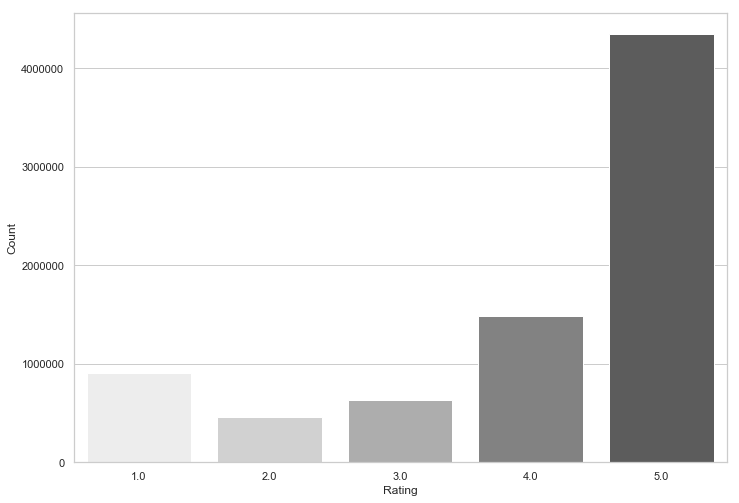

In [7]:
# Rating frequency : 

sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set_style('whitegrid')
ax = sns.countplot(x='Rating', data=amazon_ratings, palette=sns.color_palette('Greys'))
ax.set(xlabel='Rating', ylabel='Count')
plt.show()

#### Data wrangling : 

* Creating fields and measures form the existing data.        

* This helps generate more data points and validates the idealogy.        

In [8]:
# Mean rating for each Product : 

product_rating = amazon_ratings.groupby('ProductId')['Rating'].mean()
product_rating.head()

ProductId
0321732944    5.000000
0439886341    1.666667
0511189877    4.500000
0528881469    2.851852
0558835155    3.000000
Name: Rating, dtype: float64

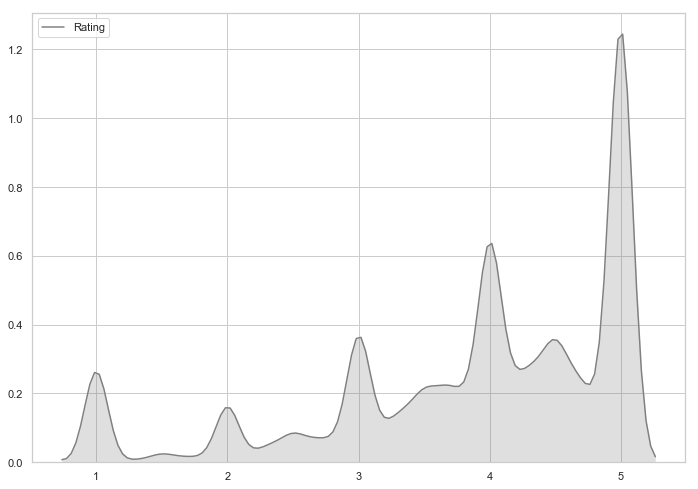

In [9]:
# Mean rating KDE distribution : 

ax = sns.kdeplot(product_rating, shade=True, color='grey')
plt.show()

###### We can notice a large spike in the mean rating at value 5. This is a valuable indicator that points to the skewness of the data. Hence we need to further analyse this issue.  

In [10]:
# Count of the number of ratings per Product : 

product_rating_count = amazon_ratings.groupby('ProductId')['Rating'].count()
product_rating_count.head()

ProductId
0321732944     1
0439886341     3
0511189877     6
0528881469    27
0558835155     1
Name: Rating, dtype: int64

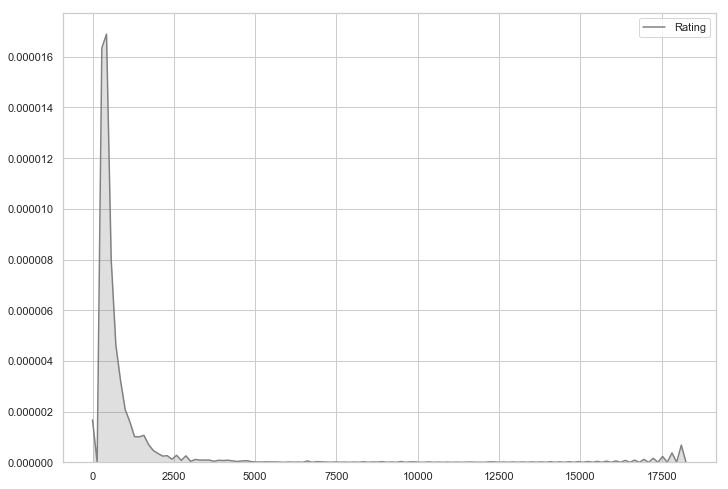

In [11]:
# Number of ratings per product KDE distribution : 

ax = sns.kdeplot(product_rating_count, shade=True, color='grey')
plt.show()

###### This graphs confirms the expectation that most items have around 50 - 100 ratings. We do have a bunch of outliers that have only a single rating and few Products have over 2000 ratings. 

In [12]:
# Un-Reliability factor : 

unreliability = amazon_ratings.groupby('ProductId')['Rating'].std(ddof = -1)
unreliability.head()

ProductId
0321732944    0.000000
0439886341    0.816497
0511189877    1.035098
0528881469    1.619164
0558835155    0.000000
Name: Rating, dtype: float64

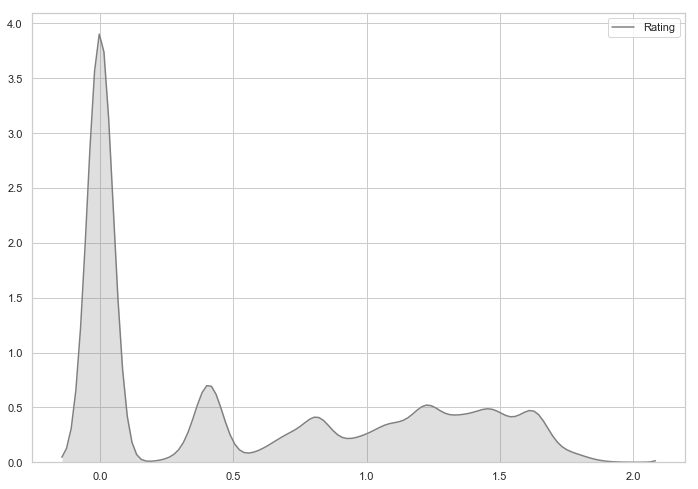

In [13]:
# Un-Reliability factor KDE distribution : 

ax = sns.kdeplot(unreliability, shade=True, color='grey')
plt.show()

###### The plot show that a large portion of the products are highly reliable. For this unreliabilit factor we used standard devaiation. But we noticed above that a large porition of the Products have a single review. These items have varying ratings but high reliability. This issue needs to be addressed. 

#### Data transforming : 

* Creating a final collection of all the various measures and features for each product.        

In [14]:
unique_products_list = amazon_ratings.ProductId.unique()
data_model = pd.DataFrame({'Rating': product_rating[unique_products_list],\
                           'Count': product_rating_count[unique_products_list], \
                          'Unreliability': unreliability[unique_products_list]})
data_model.head()

,Rating,Count,Unreliability
ProductId,,,
0321732944,5.000000,1,0.000000
0439886341,1.666667,3,0.816497
0511189877,4.500000,6,1.035098
0528881469,2.851852,27,1.619164
0558835155,3.000000,1,0.000000


**Let's explore the data model more :**

In [15]:
print("Data model shape (number of data points): %s" % str(data_model.shape))

Data model shape (number of data points): (476001, 3)


<Figure size 1170x827 with 0 Axes>

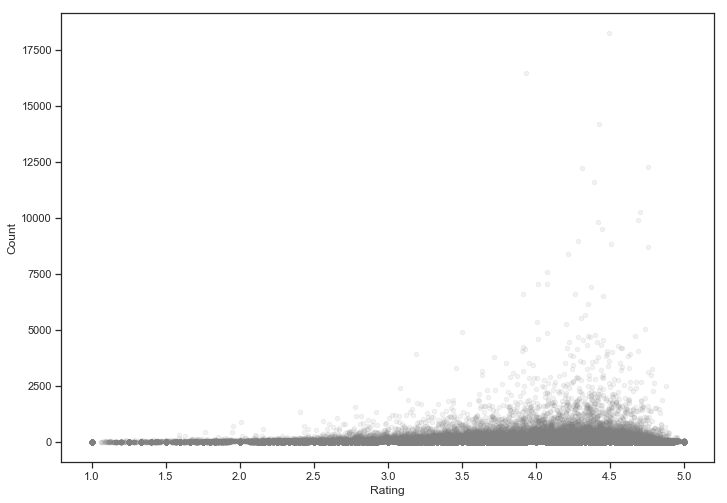

In [16]:
# Rating versus count : 

sns.set_style('ticks')
plt.figure(num=None, figsize=(11.7, 8.27), dpi=100, facecolor='w', edgecolor='k')

ax = data_model.plot(kind='scatter', x='Rating', y='Count', color='grey', alpha=0.1)
plt.show()

###### This plot fails to provide much information due to the large number of data points leading to clustered data. So let's break it down into a number of ranges. 

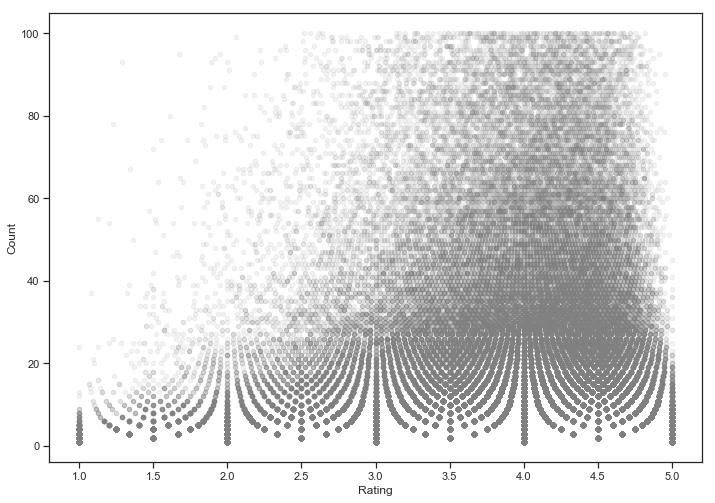

In [17]:
# Less than 100 ratings : 

ax = data_model[data_model.Count < 101].plot(kind='scatter', x='Rating', y='Count', color='grey', alpha=0.1)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


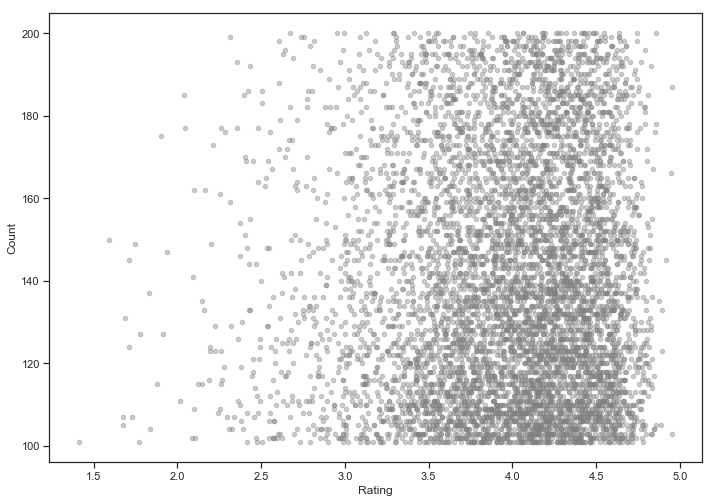

In [18]:
# 100 to 200 ratings : 

ax = data_model[data_model.Count > 100]\
[data_model.Count<201].plot(kind='scatter', x='Rating', y='Count', color='grey', alpha=0.4)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


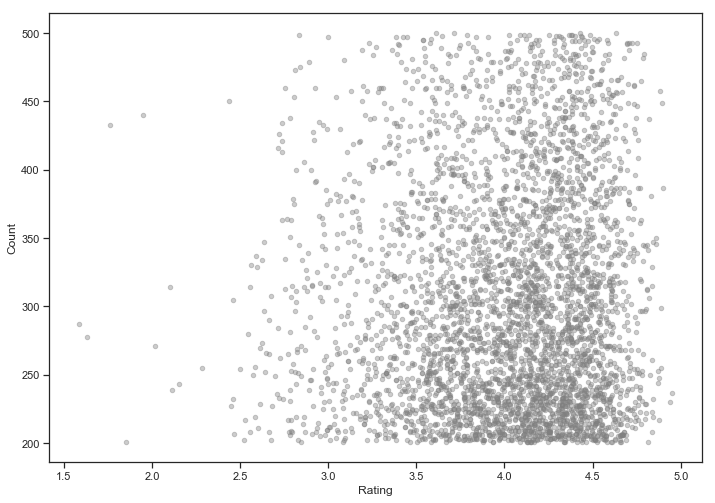

In [19]:
# 200 to 500 ratings : 

ax = data_model[data_model.Count > 200]\
[data_model.Count<501].plot(kind='scatter', x='Rating', y='Count', color='grey', alpha=0.4)
plt.show()

###### We notice that the density becomes sparse as the number of ratings (count) increases. Let's have a look if unreliability has any corelation with the count of ratings and mean rating of the Product.        

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


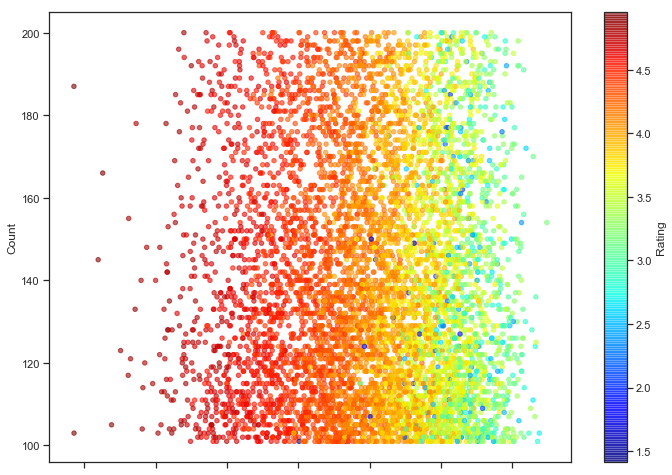

In [20]:
# Adding unreliability factor to the above plots 100 to 200 ratings : 
ax = data_model[data_model.Count > 100]\
[data_model.Count<201].plot(kind='scatter', x='Unreliability', y='Count', c='Rating', cmap='jet', alpha=0.6)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


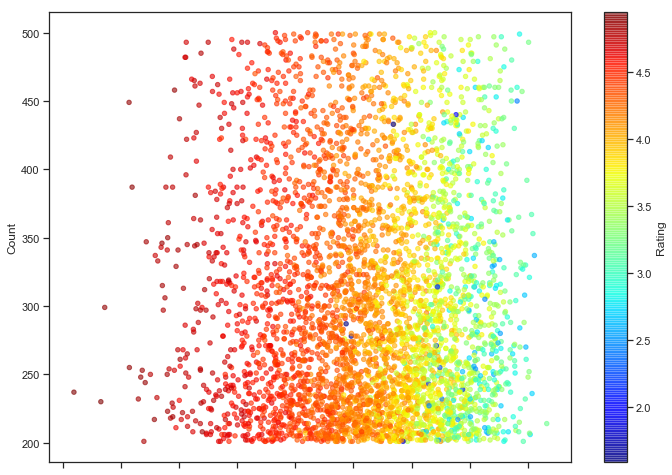

In [21]:
# Addding unreliability factor to the above plots 200 to 500 ratings : 
ax = data_model[data_model.Count > 200]\
[data_model.Count<501].plot(kind='scatter', x='Unreliability', y='Count', c='Rating', cmap='jet', alpha=0.6)
plt.show()

###### Here we see a trend. It looks like the which have a high unreliability score, seem to have a lower rating over a significant count range. Let's see if there is an corelation between these factors.        

In [22]:
# Coefficient of corelation between Unreliability and Rating : 
coeff_corelation = np.corrcoef(x=data_model.Unreliability, y=data_model.Rating)
print("Coefficient of corelation: ")
print(coeff_corelation)

Coefficient of corelation: 
[[ 1.        -0.2222165]
 [-0.2222165  1.       ]]


###### We notice that there is medium-strong negative corelation from the -0.2222165 coefficient. This means that as the unreliability factor increases, there is a medium-strong change that the rating of the product decreases. This is a good indicator as it clarifies any questions regarding unreliability.        

#### Data modelling : 


Let's see if we are ready to make prediction. If not we must model the data into an appropriate format. 

In [23]:
# Summarise Count : 
print(data_model.Count.describe())

count    476001.000000
mean         16.437951
std         112.702749
min           1.000000
25%           1.000000
50%           2.000000
75%           7.000000
max       18244.000000
Name: Count, dtype: float64


In [24]:
# Summarise Rating : 
print(data_model.Rating.describe())

count    476001.000000
mean          3.889698
std           1.128719
min           1.000000
25%           3.272727
50%           4.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64


In [25]:
# Summarise Unreliability : 
print(data_model.Unreliability.describe())

count    476001.000000
mean          0.563087
std           0.617430
min           0.000000
25%           0.000000
50%           0.408248
75%           1.188967
max           1.940285
Name: Unreliability, dtype: float64


###### It's clear that the count ranges form 1 to 7533 ratings, the Mean rating ranges from 1 to 5 and the Unrelaibility factor ranges form 0 to 1.92. These values cannot be use directly as they have a vastly varying range.  

In [26]:
# Removing outliers and improbable data points : 

data_model = data_model[data_model.Count > 50][data_model.Count < 1001].copy()
print(data_model.shape)

(25093, 3)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
# Normalization function to range 0 - 10 : 

def normalize(values):
    mn = values.min()
    mx = values.max()
    return(10.0/(mx - mn) * (values - mx)+10)

In [28]:
data_model_norm = normalize(data_model)
data_model_norm.head()

,Rating,Count,Unreliability
ProductId,,,
1400501466,6.313657,2.096944,8.245284
1400501520,8.088588,0.326660,6.736522
1400501776,7.156849,0.927292,6.945501
1400532620,6.636020,1.264489,8.278920
1400532655,6.747779,4.562698,7.690769


#### Recommendation System - Method 1 : 

Once we have modelled the data, we recomending similar items based on Count of ratings, Mean rating and the Unreliability factor. 

In [29]:
## Setting up the model : 

# Recommend 20 similar items : 
engine = KNeighborsClassifier(n_neighbors=20)

# Training data points : 
data_points = data_model_norm[['Count', 'Rating', 'Unreliability']].values

#Training labels : 
labels = data_model_norm.index.values

print("Data points: ")
print(data_points)

print("Labels: ")
print(labels)

engine.fit(data_points, labels)

Data points: 
[[2.09694415 6.31365655 8.24528378]
 [0.32665964 8.0885884  6.73652205]
 [0.92729189 7.15684891 6.94550086]
 ...
 [0.01053741 6.35757701 8.08456231]
 [0.07376185 6.51591095 8.2027859 ]
 [0.20021075 9.56890399 3.275159  ]]
Labels: 
['1400501466' '1400501520' '1400501776' ... 'B00KINSDK8' 'B00KWHMR6G'
 'B00L3YHF6O']


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

###### Now that the engine is setup and we have initialized it with the required data points and labels, we can use it to recommend a list of 20 similar items.  

Recommended products: 
[Index(['B00L3YHF6O', 'B00870KSOI', 'B000SDPMEI', 'B00142MUDI', 'B001F0MFXY',
       'B00BMR7UPS', 'B00ADE3XXY', 'B00317HUWU', 'B008UGPBXM', 'B005QSXVF2',
       'B00009R6FV', 'B0020Z8PBY', 'B006RO4VEO', 'B0045JUDJ0', 'B000EHUFLI',
       'B0013LQD7Y', 'B000IBTK7U', 'B0007RSZX0', 'B00BKUYZWS', 'B004ZL9ZPG'],
      dtype='object', name='ProductId')]


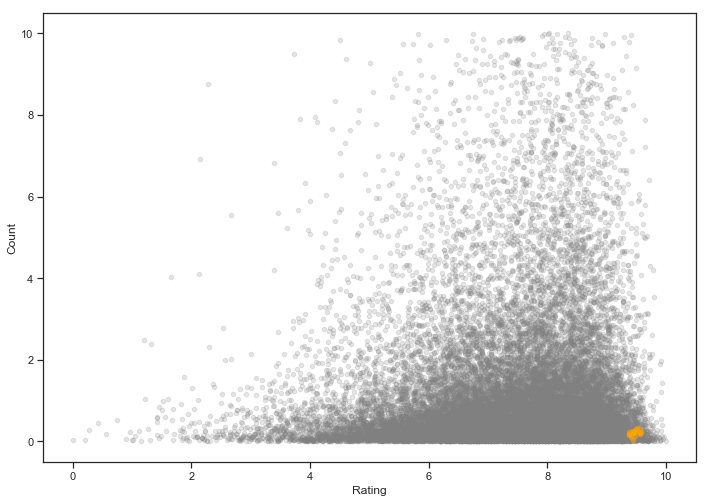

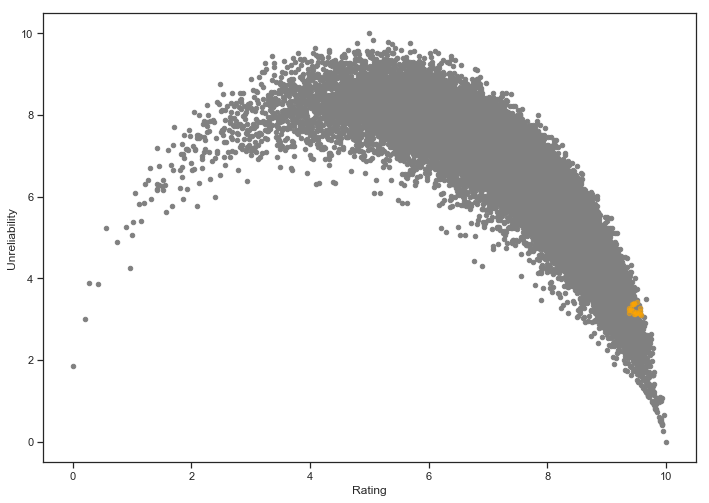

In [30]:
# Enter product ID to get a list of 20 recommended items : 

# User entered value : 
product_id = 'B00L3YHF6O'

product_data = [data_model_norm.loc[product_id][['Count', 'Rating', 'Unreliability']].values]

recommended_products = engine.kneighbors(X=product_data, n_neighbors=20, return_distance=False)

# List of product IDs form the indexes : 

products_list = []

for each in recommended_products:
    products_list.append(data_model_norm.iloc[each].index)

print("Recommended products: ")
print(products_list)

# Showing recommended products : 

ax = data_model_norm.plot(kind='scatter', x='Rating', y='Count', color='grey', alpha=0.20)
data_model_norm.iloc[recommended_products[0]].plot(kind='scatter', x='Rating', y='Count',\
                                                   color='orange', alpha=0.5, ax=ax)

ax2 = data_model_norm.plot(kind='scatter', x='Rating', y='Unreliability', color='grey')
data_model_norm.iloc[recommended_products[0]].plot(kind='scatter', x='Rating', y='Unreliability',\
                                                   color='orange', alpha=0.5, ax=ax2)
plt.show()

#### Recommendation System - Method 2 - Part I : 

###### Product popularity based recommendation system targeted at new customers.

* Popularity based are a great strategy to target the new customers with the most popular products sold on a business's website and is very useful to cold start a recommendation engine. 


* Dataset : Amazon product review datasets. 

In [31]:
popular_products = pd.DataFrame(amazon_ratings.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
B0074BW614,18244
B00DR0PDNE,16454
B007WTAJTO,14172
B0019EHU8G,12285
B006GWO5WK,12226
B003ELYQGG,11617
B003ES5ZUU,10276
B007R5YDYA,9907
B00622AG6S,9823


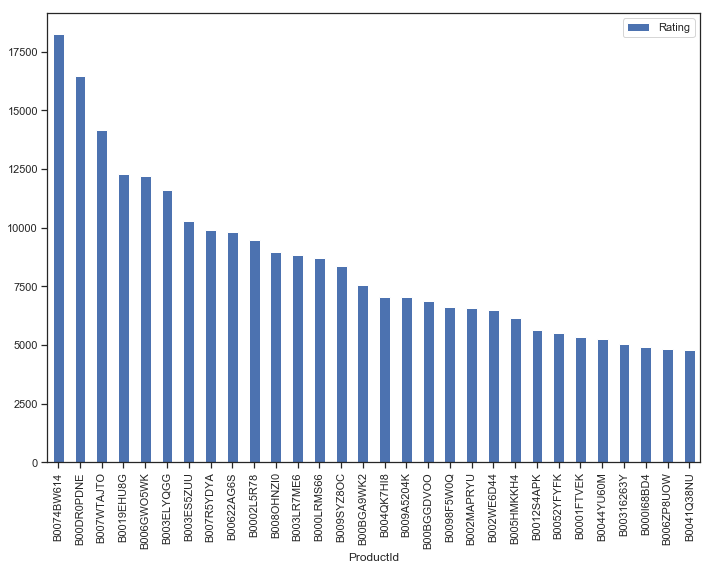

In [32]:
most_popular.head(30).plot(kind = "bar")

###### Analysis : 

* The above graph gives us the most popular products (arranged in descending order) sold by the business.

* For eaxmple, product, ID # B001MA0QY2 has sales of over 7000, the next most popular product, ID # B0009V1YR8 has sales of 3000, etc.

#### Recommendation System - Part II : 

###### Model-based collaborative filtering system. 

* Recommend items to users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer. 


* A model based collaborative filtering technique is closen here as it helps in making predictinfg products for a particular user by identifying patterns based on preferences from multiple user data.        

#### Utility Matrix based on products sold and user reviews : 


****Utility Matrix**** : An utlity matrix is consists of all possible user-item preferences (ratings) details represented as a matrix. The utility matrix is sparce as none of the users would buy all teh items in the list, hence, most of the values are unknown.

In [33]:
# Subset of Amazon Ratings : 

amazon_ratings1 = amazon_ratings.head(10000)

In [34]:
ratings_utility_matrix = amazon_ratings1.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,0321732944,0439886341,0511189877,0528881469,0558835155,059400232X,0594012015,0594017343,0594017580,0594033896,...,B00000J1DN,B00000J1DT,B00000J1E6,B00000J1EC,B00000J1EJ,B00000J1EP,B00000J1EQ,B00000J1ES,B00000J1EZ,B00000J1F3
UserId,,,,,,,,,,,,,,,,,,,,,
A00766851QZZUBOVF4JFT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A01255851ZO1U93P8RKGE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0293130VTX2ZXA70JQS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A030530627MK66BD8V4LN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0402564TCEO67AUZFJO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### As expected, the utility matrix obtaned above is sparce, I have filled up the unknown values wth 0.        

In [35]:
ratings_utility_matrix.shape

(9826, 1304)

#### Transposing the matrix : 

In [36]:
X = ratings_utility_matrix.T
X.head()

UserId,A00766851QZZUBOVF4JFT,A01255851ZO1U93P8RKGE,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,A0402564TCEO67AUZFJO,A04256643L1ZMT75HVD2P,A0590501PZ7HOWJKBGQ4,A0641581307AKT5MAOU0Q,A076219533YHEV2LJO988,A07865442XT0VEAVPSGX1,...,AZV9WA9MNT0FB,AZX0ZDVAFMN78,AZX5LAN9JEAFF,AZX7I110AF0W2,AZXFQVG0PS3V1,AZYNQZ94U6VDB,AZYTSU42BZ7TP,AZZ77XYX8O2WE,AZZGUU97OHUF1,AZZMV5VT9W7Y8
ProductId,,,,,,,,,,,,,,,,,,,,,
0321732944,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0439886341,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0511189877,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5,0,0,0,0
0528881469,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0558835155,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
X.shape

(1304, 9826)

#### Unique products in subset of data : 

In [38]:
X1 = X

#### Decomposing the Matrix : 

In [39]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(1304, 10)

#### Correlation Matrix : 

In [40]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(1304, 1304)

###### Correlation_matrix : 

* Isolating Product ID # 1616833742 from the Correlation Matrix

* Assuming the customer buys Product ID # 1616833742 (randomly chosen)

In [41]:
X.index[99]

'1616833742'

#### Index # of product ID purchased by customers : 

In [42]:
i = "1616833742"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

99

###### Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product.

In [43]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(1304,)

#### Recommending top 10 highly correlated products in sequence : 

In [44]:
Recommend = list(X.index[correlation_product_ID > 0.90])

# Removes the item already bought by the customers.
Recommend.remove(i) 

Recommend[0:10]

['0594033896',
 '0594287995',
 '0594451647',
 '0594549558',
 '0743610431',
 '0970407998',
 '1400699169',
 '1616825855',
 '1616873973',
 '1685560156']

****Product Id**** # Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.

#### Conclusion : 


* The engine recommends similar products based on feature such as number of ratings, mean ratings and unreliability factor of the Product.  

* As seen from the above output, we can alter the number of items recommended, and using this we can integrate onine sale trends into retails stores by recommending similar products to the store.  

* This also can be used as an added feature as a plus point when discussing item sales and profits with the stores. 